# Machine Failure Prediction Project

#### Machine Predictive Maintenance Classsification Information:


Since real predictive maintenance datasets are generally difficult to obtain and in particular difficult to publish, we present and provide a synthetic dataset that reflects real predictive maintenance encountered in the industry to the best of our knowledge.

The dataset consists of 10 000 data points stored as rows with 14 features in columns

UID: unique identifier ranging from 1 to 10000

productID: consisting of a letter L, M, or H for low (50% of all products), medium (30%), and high (20%) as product quality variants and a variant-specific serial number

air temperature [K]: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K
process temperature [K]: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.

rotational speed [rpm]: calculated from powepower of 2860 W, overlaid with a normally distributed noise

torque [Nm]: torque values are normally distributed around 40 Nm with an Ïƒ = 10 Nm and no negative values.
tool wear [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process. and a
'machine failure' label that indicates, whether the machine has failed in this particular data point for any of the following failure modes are true.

### Data Cleaning and Pre-processing

#### Importing the necessary libraries

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report


from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [111]:
# Reading data into a dataframe
df_machine = pd.read_csv('PdM.csv')
df_machine.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [112]:
df_machine.info

<bound method DataFrame.info of         UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0         1     M14860    M                298.1                    308.6   
1         2     L47181    L                298.2                    308.7   
2         3     L47182    L                298.1                    308.5   
3         4     L47183    L                298.2                    308.6   
4         5     L47184    L                298.2                    308.7   
...     ...        ...  ...                  ...                      ...   
9995   9996     M24855    M                298.8                    308.4   
9996   9997     H39410    H                298.9                    308.4   
9997   9998     M24857    M                299.0                    308.6   
9998   9999     H39412    H                299.0                    308.7   
9999  10000     M24859    M                299.0                    308.7   

      Rotational speed [rpm]  Torque [Nm]  

By these features listed in the dataset, it looks to be a regular industrial motor. However, the 'Tool wear [min]' feature may indicate that it is some sort of cutting tool.

In [113]:
df_machine.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [114]:
df_machine.shape

(10000, 10)

In [115]:
# Double checking for null values
df_machine.isnull().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64

In [116]:
# For our preliminary analysis, we will drop the UDI and ProductID columns
df_machine.drop(['UDI', 'Product ID', 'Failure Type'], axis=1, inplace=True)

The 'UDI' and 'Product ID' features will not assist us in predicting failures, since they are simply identifiers and IDs of the machines.

In [117]:
# We can now obtain how many machines are of each type
df_machine['Type'].value_counts()

L    6000
M    2997
H    1003
Name: Type, dtype: int64

#### Data Analysis and Visualization

#### Handling Categorical Feature - Type

In [78]:
df_machine['Type'].replace(['L', 'M', 'H'], [0, 1, 2], inplace=True)

Since the 'Type' category is a discrete ordinal value, then we can apply simple ordinal encoding to increase the accuracy of our model

We know that the dataset is highly unbalanced, and thus we should take that into account to prevent a model with undeservingly high accuracy

In [79]:
fail = df_machine[df_machine.Target == 1]
no_fail = df_machine[df_machine.Target == 0]
fail_2 = df_machine[df_machine.Target == 1]

In [80]:
failure = pd.concat([fail, fail_2])

In [81]:
fail['Tool wear [min]'].describe()

count    339.000000
mean     143.781711
std       72.759876
min        0.000000
25%       84.500000
50%      165.000000
75%      207.500000
max      253.000000
Name: Tool wear [min], dtype: float64

In [82]:
no_fail['Tool wear [min]'].describe()

count    9661.000000
mean      106.693717
std        62.945790
min         0.000000
25%        52.000000
50%       107.000000
75%       160.000000
max       246.000000
Name: Tool wear [min], dtype: float64

#### Building a sample dataset containing similar distributions of fail and no fail instances

In [83]:
no_fail_sample = no_fail.sample(n=678)

In [84]:
# Concatenating the two dataframes
new_data = pd.concat([no_fail_sample,failure], axis=0)
new_data.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
7318,2,299.9,310.3,1535,43.9,154,0
8101,0,300.3,311.8,1567,37.7,180,0
6173,0,300.8,310.7,1633,27.8,0,0
6927,0,301.1,311.6,1488,43.4,5,0
4309,1,301.3,309.9,1501,39.5,27,0


In [85]:
new_data['Target'].value_counts()

0    678
1    678
Name: Target, dtype: int64

#### Splitting Training and Testing Data

In [86]:
X = new_data.drop(columns='Target', axis=1)
Y = new_data['Target']

In [87]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, stratify=Y,random_state=2)
print(X_train.shape, Y_test.shape)

(1084, 6) (272,)


In [88]:
# Scaling the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### Model Training - Logistic Regression

In [121]:
logistic_model = LogisticRegression()
logistic_model.fit(X_train, Y_train)

LogisticRegression()

In [122]:
X_train_prediction = logistic_model.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction, Y_train)

In [123]:
print('Accuracy on Training data: ', training_data_accuracy*100,'%')

Accuracy on Training data:  82.28782287822878 %


In [124]:
X_test_prediction = logistic_model.predict(X_test)

In [125]:
test_data_accuracy = accuracy_score(X_test_prediction, Y_test)

In [126]:
print('Accuracy on Test Data Prediction: ', test_data_accuracy*100,'%')

Accuracy on Test Data Prediction:  83.45588235294117 %


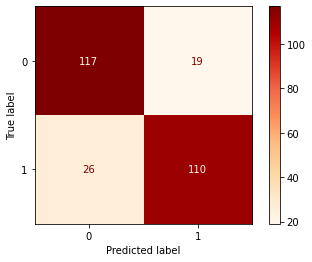

In [127]:
# Plotting the confusion matrix
plot_confusion_matrix(logistic_model, X_test,Y_test, cmap='OrRd')

In [128]:
# Checking the model's accuracy
print(classification_report(Y_test, logistic_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84       136
           1       0.85      0.81      0.83       136

    accuracy                           0.83       272
   macro avg       0.84      0.83      0.83       272
weighted avg       0.84      0.83      0.83       272



#### Model Training - Support Vector Machines

In [96]:
model_svc = svm.SVC()

In [97]:
model_svc.fit(X_train, Y_train)

SVC()

In [98]:
X_train_svc = model_svc.predict(X_train)
training_accuracy = accuracy_score(X_train_svc, Y_train)
print('Accuracy on training data prediction: ', training_accuracy*100,'%')

Accuracy on training data prediction:  90.95940959409594 %


In [99]:
X_test_predict = model_svc.predict(X_test)
test_data_accuracy_2 = accuracy_score(X_test_predict, Y_test)
print('Accuracy on testing data prediction: ', test_data_accuracy_2*100,'%')

Accuracy on testing data prediction:  89.33823529411765 %


In [100]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, model_svc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89       136
           1       0.88      0.90      0.89       136

    accuracy                           0.89       272
   macro avg       0.89      0.89      0.89       272
weighted avg       0.89      0.89      0.89       272



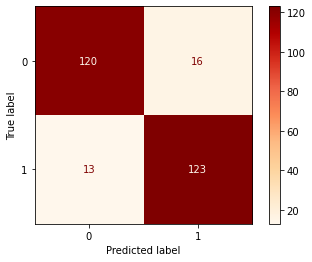

In [101]:
plot_confusion_matrix(model_svc, X_test,Y_test, cmap='OrRd')

In [120]:
# Checking the model's accuracy
print(classification_report(Y_test, model_svc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89       136
           1       0.88      0.90      0.89       136

    accuracy                           0.89       272
   macro avg       0.89      0.89      0.89       272
weighted avg       0.89      0.89      0.89       272



#### Model Training - Random Forest

In [102]:
random_forest_model=RandomForestClassifier()

In [103]:
random_forest_model.fit(X_train,Y_train)

RandomForestClassifier()

In [104]:
X_train_clf=random_forest_model.predict(X_train)
training_accuracy_clf=accuracy_score(X_train_clf,Y_train)
print('Accuracy on training data Prediction: ', training_accuracy_clf*100,'%')

Accuracy on training data Prediction:  100.0 %


In [105]:
X_test_clf=random_forest_model.predict(X_test)
testing_accuracy_clf=accuracy_score(X_test_clf,Y_test)
print('Accuracy on training data Prediction: ', testing_accuracy_clf*100,'%')

Accuracy on training data Prediction:  94.85294117647058 %


In [106]:
from sklearn.model_selection import cross_val_score
scores=cross_val_score(random_forest_model, X,Y, cv=5)
scores

array([0.96323529, 0.94833948, 0.94833948, 0.96309963, 0.96678967])

In [119]:
# Checking the model's accuracy
print(classification_report(Y_test, random_forest_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       136
           1       0.93      0.97      0.95       136

    accuracy                           0.95       272
   macro avg       0.95      0.95      0.95       272
weighted avg       0.95      0.95      0.95       272

